# K-Means Algorithm (AWS SageMaker Built-in Algorithm)
The aim of this notebook is to better understand "K-Means Algorithm" in AWS SageMaker service and to train on the SageMaker SDK.<br>
Link to "K-Means Algorithm" documentation by AWS:
https://docs.aws.amazon.com/sagemaker/latest/dg/k-means.html

### Short Explanation 
K-Means is **unsupervised** algorithm that attempts to find discrete groupings within data, where members of a group are as similar as possible to one another and as different as possible from members of other groups. The Euclidean distance between these points represents the similarity of the corresponding observations. 

### Inputs
For training:
- application/x-recordio-protobuf
- text/csv

For inference:
- recordIO-wrapped-protobuf
- text/csv
- application/json

### Output
k-means returns a *closest_cluster label* and the *distance_to_cluster* for each observation.

### EC2 Instance Recommendation
CPU instances

### Hyperparameters
- [K-Means Hyperparameters](#https://docs.aws.amazon.com/sagemaker/latest/dg/k-means-api-config.html)
- [Automatic model tuning](#https://docs.aws.amazon.com/sagemaker/latest/dg/k-means-tuning.html)

## Table Of Contents
1. [Data Collection](#d)
1. [Data Preparation](#p)
1. [EDA](#e)
1. [Train Model](#tm)
1. [Results](#r)

    
<u>_**General Note:</u> in every code cell that I'm using external libraries I'm importing it every time, although I can import all of them once on the start of the notebook, I wanted to show what libraries I'm using on every step**_

## Data Collection<a id='d'></a>
<a href="https://www.kaggle.com/leonardopena/top50spotify2019"> Top 50 Spotify Songs - 2019</a> dataset from Kaggle. this dataset is The top 50 most listened songs in the world by spotify. This dataset has several variables about the songs.

Dataset Explanation
- Index 
- Track Name
- Artist Name
- Genre - the genre of the track
- Year - the release year of the recording. Note that due to vagaries of releases, re-releases, re-issues and general - madness, sometimes the release years are not what you'd expect.
- Added - the earliest date you added the track to your collection.
- Beats Per Minute (BPM) - The tempo of the song.
- Energy - The energy of a song - the higher the value, the more energtic. song
- Danceability - The higher the value, the easier it is to dance to this song.
- Loudness (dB) - The higher the value, the louder the song.
- Liveness - The higher the value, the more likely the song is a live recording.
- Valence - The higher the value, the more positive mood for the song.
- Length - The duration of the song.
- Acousticness - The higher the value the more acoustic the song is.
- Speechiness - The higher the value the more spoken word the song contains.
- Popularity - The higher the value the more popular the song is.

    

In [1]:
import pandas as pd 

file_name="./data/top50.csv"
data = pd.read_csv(file_name,encoding = "ISO-8859-1")
data.head()

,Unnamed: 0,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
0,1,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
1,2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92
2,3,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85
3,4,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86
4,5,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94


## Data Preparation<a id='p'></a>
### handling missing value

In [2]:
data.isnull().sum()

Unnamed: 0          0
Track.Name          0
Artist.Name         0
Genre               0
Beats.Per.Minute    0
Energy              0
Danceability        0
Loudness..dB..      0
Liveness            0
Valence.            0
Length.             0
Acousticness..      0
Speechiness.        0
Popularity          0
dtype: int64

no missing values in the dataset

### feature selection
We can drop 'Unnamed: 0' - it's index column

In [3]:
data.drop(columns=['Unnamed: 0'], inplace=True)

K-Means algorithm is working well with numerical features (because it's using euclidean distance) but not with categorical, hence we will remove "Track.Name", "Artist.Name" and "Genre" from the training dataset.

still we will save the "Track.Name", "Artist.Name" and "Genre" on other dataFrame for future use.

In [4]:
track_pd=data[['Track.Name','Artist.Name','Genre']].copy()
data.drop(columns=['Track.Name','Artist.Name','Genre'], inplace=True)
data.head()

,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
0,117,55,76,-6,8,75,191,4,3,79
1,105,81,79,-4,8,61,302,8,9,92
2,190,80,40,-4,16,70,186,12,46,85
3,93,65,64,-8,8,55,198,12,19,86
4,150,65,58,-4,11,18,175,45,7,94


now all the features are numerical

## EDA<a id='e'></a>

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("paper", font_scale=1.4)

In [6]:
data.describe()

,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,120.060000,64.060000,71.38000,-5.660000,14.660000,54.600000,200.960000,22.160000,12.480000,87.500000
std,30.898392,14.231913,11.92988,2.056448,11.118306,22.336024,39.143879,18.995553,11.161596,4.491489
min,85.000000,32.000000,29.00000,-11.000000,5.000000,10.000000,115.000000,1.000000,3.000000,70.000000
25%,96.000000,55.250000,67.00000,-6.750000,8.000000,38.250000,176.750000,8.250000,5.000000,86.000000
50%,104.500000,66.500000,73.50000,-6.000000,11.000000,55.500000,198.000000,15.000000,7.000000,88.000000
75%,137.500000,74.750000,79.75000,-4.000000,15.750000,69.500000,217.500000,33.750000,15.000000,90.750000
max,190.000000,88.000000,90.00000,-2.000000,58.000000,95.000000,309.000000,75.000000,46.000000,95.000000


let's round the numbers to 3 digit

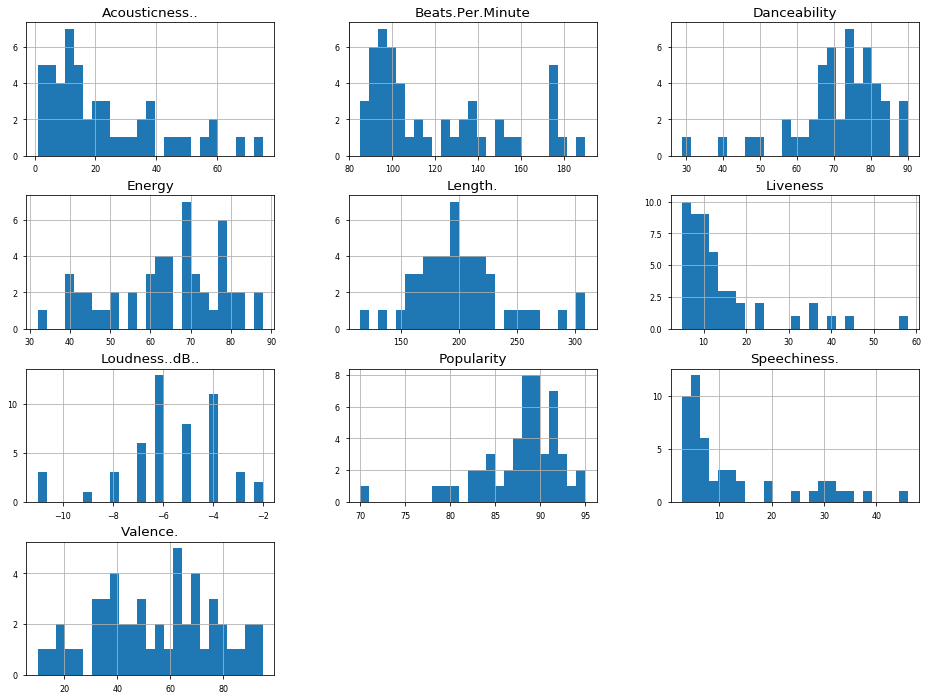

In [7]:
data.hist(figsize=(16, 12), bins=25, xlabelsize=8, ylabelsize=8)
plt.show(block = False)

we don't need to randomize or split the data, it unsupervised algorithm, we just want to cluster.

## Train Model<a id='tm'></a>
as mentioned above, "K-Means Algorithm" possible inputs for training are: application/x-recordio-protobuf
or text/csv. we will try them both for practice purposes.

### Input - CSV
Create CSV files and Upload to S3

In [8]:
# creating CSV file
file_name='cleaned_Top50Spotify.csv'
data.to_csv(file_name, index=False, header=False)

# Next we can take the file we just stored onto our Notebook instance and upload it to S3.
import boto3

bucket_name = 'allcloud-idan-aws-certified-ml-2019'
folder_path = 'AWS SageMaker Built-in Algorithms/K-Means Algorithm/'
boto3.Session().resource('s3').Bucket(bucket_name).Object(folder_path+file_name).upload_file(file_name)

In [9]:
import sagemaker

# create inputs that our training function can use as a pointer to the files in S3 
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/'.format(bucket_name)+folder_path+file_name, content_type='text/csv;label_size=0')

Create a training job

In [10]:
# Here is where the model artifact will be stored
output_location = 's3://{}/{}'.format(bucket_name,folder_path+'output/')

# get IAM role
from sagemaker import get_execution_role
role = get_execution_role()

# Configure training job, establish SagMaker session
sess = sagemaker.Session()

# get ECR container
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'kmeans','1')

# create Estimator
kmeans_conf = sagemaker.estimator.Estimator(container,
                                            role,
                                            train_instance_count=1,
                                            train_instance_type='ml.c5.xlarge',
                                            output_path=output_location,
                                            sagemaker_session=sess,
                                            input_mode='File')

#for 'train_instance_type' go to https://aws.amazon.com/sagemaker/pricing/instance-types/

Train the Model

In [11]:
from datetime import datetime

training_job_name_1='Top50Spotify-kmeans-csv-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

# for 'hyperparameters' go to: https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
kmeans_conf.set_hyperparameters(feature_dim=10,
                                k=3)

data_channels = {
    'train': s3_input_train
} 

In [12]:
%%time
kmeans_conf.fit(inputs=data_channels,logs=True,job_name=training_job_name_1)
print('this training job name is: '+training_job_name_1)

2019-12-14 10:58:16 Starting - Starting the training job...
2019-12-14 10:58:18 Starting - Launching requested ML instances...
2019-12-14 10:59:14 Starting - Preparing the instances for training......
2019-12-14 11:00:14 Downloading - Downloading input data
2019-12-14 11:00:14 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[12/14/2019 11:00:29 INFO 140450651387712] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'm


2019-12-14 11:00:39 Uploading - Uploading generated training model
2019-12-14 11:00:39 Completed - Training job completed
Training seconds: 48
Billable seconds: 48
this training job name is: Top50Spotify-kmeans-csv-20191214105816
CPU times: user 341 ms, sys: 23.8 ms, total: 365 ms
Wall time: 2min 41s


### Input - x-recordio-protobuf | version 1 (recordIO file from S3)

In [13]:
#convert to numpy.ndarray
data_matrix = data.as_matrix()

#create recordIO file
import io
import sagemaker.amazon.common as smac
file_name='cleaned_Top50Spotify.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, data_matrix.astype('float32'))
f.seek(0)

#upload it to S3.
import boto3

bucket_name = 'allcloud-idan-aws-certified-ml-2019'
folder_path = 'AWS SageMaker Built-in Algorithms/K-Means Algorithm/'
boto3.Session().resource('s3').Bucket(bucket_name).Object(folder_path+file_name).upload_fileobj(f)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [14]:
# Here is where the model artifact will be stored
output_location = 's3://{}/{}'.format(bucket_name,folder_path+'output/')

# get IAM role
from sagemaker import get_execution_role
role = get_execution_role()

# Configure training job, establish SagMaker session
sess = sagemaker.Session()

# get ECR container
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'kmeans','1')

# create Estimator
kmeans_conf = sagemaker.estimator.Estimator(container,
                                            role,
                                            train_instance_count=1,
                                            train_instance_type='ml.c5.xlarge',
                                            output_path=output_location,
                                            sagemaker_session=sess,
                                            input_mode='Pipe')

#for 'train_instance_type' go to https://aws.amazon.com/sagemaker/pricing/instance-types/

In [15]:
from datetime import datetime

training_job_name_2='Top50Spotify-kmeans-recordIO-1-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

# for 'hyperparameters' go to: https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
kmeans_conf.set_hyperparameters(feature_dim=10,
                                k=3)

s3_input_train = 's3://{}/{}{}'.format(bucket_name,folder_path,file_name)

data_channels = {
    'train': s3_input_train
}

In [16]:
%%time
kmeans_conf.fit(inputs=data_channels,logs=True, job_name=training_job_name_2)
print('this training job name is: '+training_job_name_2)

2019-12-14 11:00:58 Starting - Starting the training job...
2019-12-14 11:01:00 Starting - Launching requested ML instances...
2019-12-14 11:01:58 Starting - Preparing the instances for training......
2019-12-14 11:02:46 Downloading - Downloading input data...
2019-12-14 11:03:26 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[12/14/2019 11:03:28 INFO 140114845538112] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u


2019-12-14 11:03:39 Uploading - Uploading generated training model
2019-12-14 11:03:39 Completed - Training job completed
Training seconds: 53
Billable seconds: 53
this training job name is: Top50Spotify-kmeans-recordIO-1-20191214110058
CPU times: user 409 ms, sys: 29.6 ms, total: 438 ms
Wall time: 3min 11s


### Input - x-recordio-protobuf | Version 2 (RecordSet from notebook)

In [17]:
# Here is where the model artifact will be stored
output_location = 's3://{}/{}'.format(bucket_name,folder_path+'output/')

# get IAM role
from sagemaker import get_execution_role
role = get_execution_role()

# Configure training job, establish SagMaker session
sess = sagemaker.Session()

In [18]:
from sagemaker import KMeans

kmeans_estimator_conf = KMeans(role=role,
                               train_instance_count=1,
                               train_instance_type='ml.c5.xlarge',
                               output_path=output_location,
                               k=3)

from datetime import datetime

training_job_name_3='Top50Spotify-kmeans-recordIO-2-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

In [20]:
# convert our DataFrame to numpy.ndarray because kmeans.record_set() Build a RecordSet from a numpy ndarray matrix
# https://sagemaker.readthedocs.io/en/stable/kmeans.html
numpy_input_train=data.to_numpy(dtype='float32')
recordSet_input_train=kmeans_estimator_conf.record_set(numpy_input_train)

In [21]:
%%time
kmeans_estimator_conf.fit(recordSet_input_train,logs=True,job_name=training_job_name_3)
print('this training job name is: '+training_job_name_3)

2019-12-14 11:05:44 Starting - Starting the training job...
2019-12-14 11:05:45 Starting - Launching requested ML instances...
2019-12-14 11:06:43 Starting - Preparing the instances for training......
2019-12-14 11:07:30 Downloading - Downloading input data...
2019-12-14 11:08:15 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[12/14/2019 11:08:17 INFO 139633136183104] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u


2019-12-14 11:08:28 Uploading - Uploading generated training model
2019-12-14 11:08:28 Completed - Training job completed
Training seconds: 58
Billable seconds: 58
this training job name is: Top50Spotify-kmeans-recordIO-2-20191214110411
CPU times: user 523 ms, sys: 23.5 ms, total: 547 ms
Wall time: 3min 11s


## Results<a id='r'></a>
we trained three times using the same dataset, hyperparameters, and algorithm.
it was just to show the different options.<br>
now let's see how the model cluster the different tracks using one of the trained models

In [28]:
# Batch Transform
#https://sagemaker.readthedocs.io/en/stable/kmeans.html
kmeans_tran=kmeans_estimator_conf.transformer(instance_count=1,
                                              instance_type='ml.c5.xlarge')

# CSV version
''' 
kmeans_tran.transform(data='s3://allcloud-idan-aws-certified-ml-2019/AWS SageMaker Built-in Algorithms/K-Means Algorithm/cleaned_Top50Spotify.csv',
                      content_type='text/csv',
                      split_type='Line',
                      job_name=training_job_name_3+'-BT-3',
                      logs=True)
'''

# recordio version
kmeans_tran.transform(data='s3://allcloud-idan-aws-certified-ml-2019/AWS SageMaker Built-in Algorithms/K-Means Algorithm/cleaned_Top50Spotify.data',
                      content_type='application/x-recordio-protobuf',
                      split_type='RecordIO',
                      job_name=training_job_name_3+'-BT-4',
                      logs=True)

Using already existing model: Top50Spotify-kmeans-recordIO-2-20191214110411


In [40]:
import json
import io
from urllib.parse import urlparse

def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')

output = get_csv_output_from_s3(kmeans_tran.output_path, '{}.out'.format('cleaned_Top50Spotify.data'))
output_df = pd.read_json(output, lines=True)
output_df.head()

,closest_cluster,distance_to_cluster
0,1,39.804893
1,2,50.332642
2,0,64.699303
3,1,20.380560
4,0,53.525986


now we know what track belong to what group, let's join the cluster group with the track info DataFrame that was saved earlier

In [41]:
track_pd.head()

,Track.Name,Artist.Name,Genre
0,Señorita,Shawn Mendes,canadian pop
1,China,Anuel AA,reggaeton flow
2,boyfriend (with Social House),Ariana Grande,dance pop
3,Beautiful People (feat. Khalid),Ed Sheeran,pop
4,Goodbyes (Feat. Young Thug),Post Malone,dfw rap


In [89]:
track_clusterd_pd=pd.merge(track_pd, output_df, right_index=True, left_index=True)
track_clusterd_pd = track_clusterd_pd.sort_values(by ='Artist.Name' , ascending=False)
track_clusterd_pd.head()

,Track.Name,Artist.Name,Genre,closest_cluster,distance_to_cluster
33,The London (feat. J. Cole & Travis Scott),Young Thug,atl hip hop,1,42.951553
18,Lalala,Y2K,canadian hip hop,0,38.706429
26,Dance Monkey,Tones and I,australian pop,1,48.043030
48,Call You Mine,The Chainsmokers,edm,1,36.574303
30,Takeaway,The Chainsmokers,edm,1,51.615238


let's create heatmap to watch Genres vs. Track and Artist Names divided to the different groups	

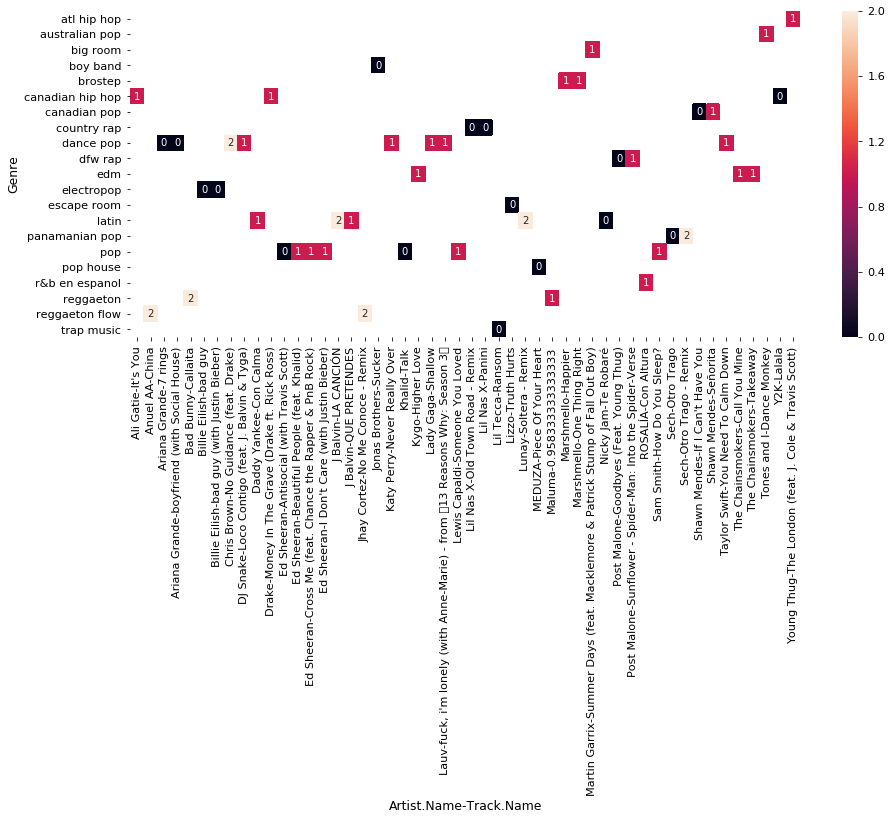

In [90]:
heatmap1_data = pd.pivot_table(track_clusterd_pd, 
                               values='closest_cluster', 
                               index=['Genre'], 
                               columns=['Artist.Name','Track.Name'])

import seaborn as sns
%matplotlib inline

plt.figure(figsize=(15, 6))
sns.heatmap(heatmap1_data, annot=True)

we can see that some Genres are clusterd in more them one group, it's don't mean anything I just assumed that some Generes would fall to spacific cluster group. maybe it because we have a very small dataset (50 rows) or maybe music geners could have overlapping values when taking in account only the features that we used in this dataset.<br>
anyway, it was fun to explore AWS SageMaker SDK. until the next time. PEACE OUT!